## Transfer Learning with MobileNet 

#### We will customise MobileNet, a lighweight, pretrained CNN for general image recognition, and use it for the most essential classification problem that ever existed - `dogs vs cats!`

---

#### Objectives:
* Test Mobilenet first
* Prepare some new dataset of images
* Create a shaved mobilenet, missing output layers
* Add our new layers 
* Freeze the training so it trains the new layers only
* wrap this into a new model class
* train and test our new model
* when we're happy, save the architecture (json) and the weights (h5)

---

### Imports

In [31]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, imagenet_utils
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2


ImportError: cannot import name 'imagenet_utils' from 'tensorflow.keras.applications' (/anaconda3/envs/deep_learning/lib/python3.7/site-packages/tensorflow/_api/v1/keras/applications/__init__.py)

  Using cached opencv_python-4.2.0.34-cp37-cp37m-macosx_10_9_x86_64.whl (49.1 MB)


#### Reset the session when you wish to reinitialise a different architecture

In [17]:
K.clear_session()
keras.__version__

'2.2.4-tf'

#### Instantiate Mobilenet

In [24]:
mobile = MobileNet()

#### Prepare an image for MobileNet
* read into an array
* ensure the shape is correct
* for both steps, we can use a mixture of `opencv` and `numpy`

In [25]:
def process_for_mobilenet(file):
    #read the image into array
    #resize the array
    image = cv2.imread(file)
    #Interpolation is to not lose info on squishing
    image = cv2.resize(image, dsize=(224,224),interpolation=cv2.INTER_CUBIC)
    image = preprocess_input(image)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


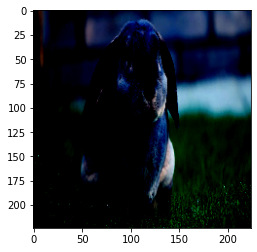

In [26]:
rabbit = process_for_mobilenet('./rabbit.jpeg')
plt.imshow(rabbit)

In [27]:
rabbit.shape

(224, 224, 3)

#### We're going to add a dimension so that mobilenet accepts it

In [28]:
#Listify image!
rabbit = np.expand_dims(rabbit, axis = 0)
rabbit.shape

(1, 224, 224, 3)

#### Test Mobilenet on the image to test it works

In [29]:
predictions = mobile.predict(rabbit)

In [32]:
results = np.argmax(predictions)

In [33]:
results

331

#### Now onto the real task, Transfer Learning

---

### Part 1: Chop and Customise

#### We chop when we import

In [34]:
new_mobile = MobileNet(weights='imagenet', include_top = False, input_shape = (224, 224, 3))

17227776/17225924 [==============================] - 6s 0us/step


#### And check the layers

In [35]:
new_mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [36]:
len(new_mobile.layers)

87

#### Now add our own custom layers - the syntax here is different from the usual keras model creation
* First create your new_layer variable
* Then build a Keras `Model`, with inputs = the old mobilenet, and outputs = the new layers

In [37]:
new_layers = new_mobile.output
new_layers = GlobalAveragePooling2D()(new_layers)
new_layers = Dense(1024, activation='relu')(new_layers)
new_layers = Dense(512, activation='relu')(new_layers)
new_layers = Dense(512, activation='relu')(new_layers)
new_layers = Dense(2, activation='softmax')(new_layers) # the only required one bcs we chopped off the original one

### Put Models together

In [38]:
new_mobile = Model(inputs=new_mobile.inputs, outputs = new_layers)

### 2: Freeze the layer weights that we don't want to train

In [39]:
len(new_mobile.layers)

92

In [40]:
for i, layer in enumerate(new_mobile.layers):
    if i < 87:
        layer.trainable = False
    else:
        layer.trainable = True

### 3: Prepare our images
#### First, take a look at an example

In [43]:
!pip install tqdm

     |████████████████████████████████| 60 kB 1.0 MB/s eta 0:00:011


#### Now read in each image, and resize and preprocess it. We can also create our y data at the same time

In [45]:
import tqdm

In [47]:
X = []
y = []
path = '/Users/iremn/Downloads/train_short/'
train_data = os.listdir(path)

for picture in tqdm.tqdm(train_data):
    image = process_for_mobilenet(path+picture)
    X.append(image)
    if 'cat' in picture:
        y.append(0)
    elif 'dog' in picture:
        y.append(1) 
X = np.array(X)
y = np.array(y)

100%|██████████| 2705/2705 [00:13<00:00, 197.80it/s]


#### The overall shape of X needs to be (no.of.images, 224,224,3), and y needs to be (no.of.images,no.of_classes)
* The shape of X should already be ok (but use `np.expand_dims` if you have one pic only)
* But we can reshape y using `keras.utils.np_utils.to_categorical`

In [50]:
y = to_categorical(y)

In [51]:
y.shape

(2705, 2)

#### Finally, lets do a train/test split

### 4: Train and test!
#### Compile, fit and evaluate

In [52]:
new_mobile.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
results = new_mobile.fit(X,y, epochs=5, batch_size=128, validation_split=0.2)

Train on 2164 samples, validate on 541 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2164/2164 [==============================] - 220s 102ms/sample - loss: 7.5412 - acc: 0.5166 - val_loss: 7.7462 - val_acc: 0.5194
Epoch 2/5
2164/2164 [==============================] - 203s 94ms/sample - loss: 7.9771 - acc: 0.5051 - val_loss: 7.7462 - val_acc: 0.5194
Epoch 3/5
2164/2164 [==============================] - 176s 82ms/sample - loss: 7.9771 - acc: 0.5051 - val_loss: 7.7462 - val_acc: 0.5194
Epoch 4/5
2164/2164 [==============================] - 176s 81ms/sample - loss: 7.9771 - acc: 0.5051 - val_loss: 7.7462 - val_acc: 0.5194
Epoch 5/5
2164/2164 [==============================] - 194s 90ms/sample - loss: 7.9771 - acc: 0.5051 - val_loss: 7.7462 - val_acc: 0.5194


---

#### Further work:
* Save the model (json) with its current weights (h5) to disk
* And load from disk

#### Save the model

In [ ]:
with open("model.json", "w") as json_file:
   json_file.write(new_mobile.to_json())
# serialize weights to HDF5
new_mobile.save_weights("model.h5")

#### Load the model

In [ ]:
from keras.models import model_from_json

# load json and create model
with open('model.json', 'r') as f:
   json = f.read()
model = model_from_json(json)

# load weights into new model
model.load_weights("model.h5")